In [1]:
import pandas as pd
import glob
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import numpy as np
# https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees

### Loading  Data

In [2]:
train_data = pd.read_csv("C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Feb 18th\\summary_card\\df_train_summary.csv")
test_data = pd.read_csv("C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Feb 18th\\summary_card\\df_test_summary.csv")

In [3]:
print(train_data.shape)
test_data.shape

(201917, 95)


(123623, 93)

### Functions to concatenate features, kfold splits

In [4]:
def feature_concat(train_data1,filepath):
    for file in filepath:
        data_features = pd.read_csv(file)
        train_data1=pd.merge(train_data1,data_features,how='left',on='card_id')
    return(train_data1)

In [5]:
def kfold_split(splitcount,train_data1,ignore_cols):  
    output_feature=['target']
    input_features=[x for x in train_data1.columns if x not in ignore_cols]
    train_X = train_data1[input_features]
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    train_X = train_X.select_dtypes(include=numerics)
    train_y = train_data1[output_feature]
    kf = StratifiedKFold(n_splits=splitcount, random_state=2018, shuffle=True)
    counter=0
    models=[]
    splits={}
    for dev_index, val_index in kf.split(train_X,train_data1['target_bin']):
        dev_X, val_X = train_X.loc[dev_index, :], train_X.loc[val_index, :]
        dev_y, val_y = train_y.loc[dev_index], train_y.loc[val_index]
        splits[counter] = [dev_X, val_X,dev_y, val_y]
        counter=counter+1
    return splits

### Concatenate features

In [6]:
%%time
file_list = glob.glob("C:/Kaggle competetion datasets/Elo Merchent Category Recommendation/Elo Feb 18th/date_trans_summary/*.csv")
train_features = feature_concat(train_data,file_list)

Wall time: 7.32 s


In [7]:
train_features.shape

(201917, 115)

In [8]:
train_features.head()

,Unnamed: 0,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_category_1_2_3_nunique,hist_month_nunique,hist_hour_nunique,...,b1.5-max_y,nan_y,qua2_x,qua3_x,qua4_x,qua5_x,qua2_y,qua3_y,qua4_y,qua5_y
0,0,2017-06-01,C_ID_92a2005557,0.013145,0.008752,0.011428,-0.820283,3,9,23,...,NaN,7.0,-72.891881,-58.178732,-34.898127,NaN,122.0,86.0,52.0,NaN
1,1,2017-01-01,C_ID_3d0044924f,0.010712,0.011385,0.010283,0.392913,5,12,24,...,NaN,4.0,-93.575634,-48.985271,-41.961159,-25.484273,140.0,87.0,67.0,56.0
2,2,2016-08-01,C_ID_d639edf6cd,0.010610,0.008752,0.010283,0.688056,2,10,14,...,NaN,1.0,-2.202346,-6.173612,-4.143170,-16.648263,4.0,9.0,6.0,24.0
3,3,2017-09-01,C_ID_186d6a6901,0.010712,0.014166,0.010283,0.142495,6,6,16,...,NaN,5.0,-20.371833,-29.119532,NaN,NaN,35.0,42.0,NaN,NaN
4,4,2017-11-01,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,-0.159749,5,4,22,...,NaN,8.0,-48.687656,NaN,NaN,NaN,133.0,NaN,NaN,NaN


In [20]:
# train_features=train_data.copy()

In [ ]:
# # Create correlation matrix
# corr_matrix = train_features.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# train_features=train_features1.drop(to_drop, axis=1).copy()

### Binning target variable

In [9]:
# Binning the numeric variable to different categories
target_std=train_features['target'].std()
max_target=train_features['target'].max()+1
min_target=train_features['target'].min()-1
bins=[min_target,-3*target_std,-2*target_std,-1*target_std,target_std*1,target_std*2,target_std*3,max_target]
labels=[-4,-3,-2,0,2,3,5]
train_features['target_bin']=pd.cut(train_features['target'],bins=bins,labels=labels).astype(int)
train_features['target_bin']=train_features['target_bin'].abs()
train_features.groupby(['target_bin']).size()


target_bin
0    191093
2      8200
3       363
4      2237
5        24
dtype: int64

### KFold Splits

In [10]:
%%time
kfolds=kfold_split(5,train_features,['first_active_month', 'card_id','target','target_bin','year_nunique_y','year_nunique_x', 'outliers', 'Unnamed: 0'])

Wall time: 1.94 s


### LGBM

In [11]:
def run_lgb(train_X, train_y, val_X, val_y):
    param = {'num_leaves': 30,
             'min_data_in_leaf': 177,
             'objective': 'regression',
             'max_depth': 9,
             'learning_rate': 0.01,
             "boosting": "gbdt",
#              "feature_fraction": 0.7,
             "bagging_freq": 1,
             "bagging_fraction": 0.7,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "random_state": 133,
             "verbosity": -1}

    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(param, lgtrain, 2000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100,
                      evals_result=evals_result)
    return model, evals_result

In [12]:
best_iter_dict = {}
best_score_dict = {} 
feature_imp = pd.DataFrame()

eval_results_dict = {}
for split in range(0,5):
    model, evals_result = run_lgb(kfolds[split][0], kfolds[split][2], kfolds[split][1], kfolds[split][3])
    
    best_iter_dict.update({split:model.best_iteration})
    best_score_dict.update({split:model.best_score.get('valid_0').get('rmse')})
    feature_imp[split] = model.feature_importance()

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.69857
[200]	valid_0's rmse: 3.66359
[300]	valid_0's rmse: 3.6501
[400]	valid_0's rmse: 3.64283
[500]	valid_0's rmse: 3.63887
[600]	valid_0's rmse: 3.63655
[700]	valid_0's rmse: 3.63531
[800]	valid_0's rmse: 3.6342
[900]	valid_0's rmse: 3.63358
[1000]	valid_0's rmse: 3.63337
Early stopping, best iteration is:
[966]	valid_0's rmse: 3.63329
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.72198
[200]	valid_0's rmse: 3.69044
[300]	valid_0's rmse: 3.67867
[400]	valid_0's rmse: 3.67276
[500]	valid_0's rmse: 3.66858
[600]	valid_0's rmse: 3.66624
[700]	valid_0's rmse: 3.66477
[800]	valid_0's rmse: 3.66368
[900]	valid_0's rmse: 3.66282
[1000]	valid_0's rmse: 3.6625
[1100]	valid_0's rmse: 3.66213
[1200]	valid_0's rmse: 3.66247
Early stopping, best iteration is:
[1129]	valid_0's rmse: 3.662
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse:

In [13]:
best_iter_df = pd.DataFrame.from_dict(best_iter_dict, orient='index')
best_score_df = pd.DataFrame.from_dict(best_score_dict, orient='index')
feature_imp['Mean'] = feature_imp.mean(axis=1) 
feature_imp['Col_Names'] = kfolds[split][0].head().columns

In [14]:
feature_imp = feature_imp.sort_values(by='Mean',ascending=False)

In [15]:
feature_imp.head()

,0,1,2,3,4,Mean,Col_Names
29,1549,1791,2343,1970,1543,1839.2,hist_month_diff_mean
80,962,1208,1382,1290,1078,1184.0,new_hist_purchase_date_uptonow
31,941,1115,1426,1145,991,1123.6,hist_authorized_flag_mean
55,994,1102,1326,1135,934,1098.2,new_hist_purchase_amount_max
34,779,975,1109,1097,807,953.4,hist_category_1_sum


In [16]:
best_iter_df

,0
0,966
1,1129
2,1384
3,1230
4,981


In [17]:
best_score_df

,0
0,3.633291
1,3.661999
2,3.643375
3,3.667006
4,3.646135


In [18]:
best_score_df.columns = ['date-trans-summary-feb19th']

In [19]:
df = pd.read_excel('C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Feb 18th\\best_scores.xlsx')
df.head()

,18th_feb_features,ref_first_last_feb19th,hist_future_diffsummary-feb19th
0,3.632611,3.632346,3.636747
1,3.666208,3.666200,3.667171
2,3.642413,3.639907,3.642815
3,3.667577,3.665989,3.670279
4,3.645449,3.644444,3.643479


In [20]:
df['date-trans-summary-feb19th'] = best_score_df['date-trans-summary-feb19th']

In [21]:
df.to_excel('C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Feb 18th\\best_scores.xlsx',index=False)

In [22]:
best_score_df.mean(axis=0)

date-trans-summary-feb19th    3.650361
dtype: float64

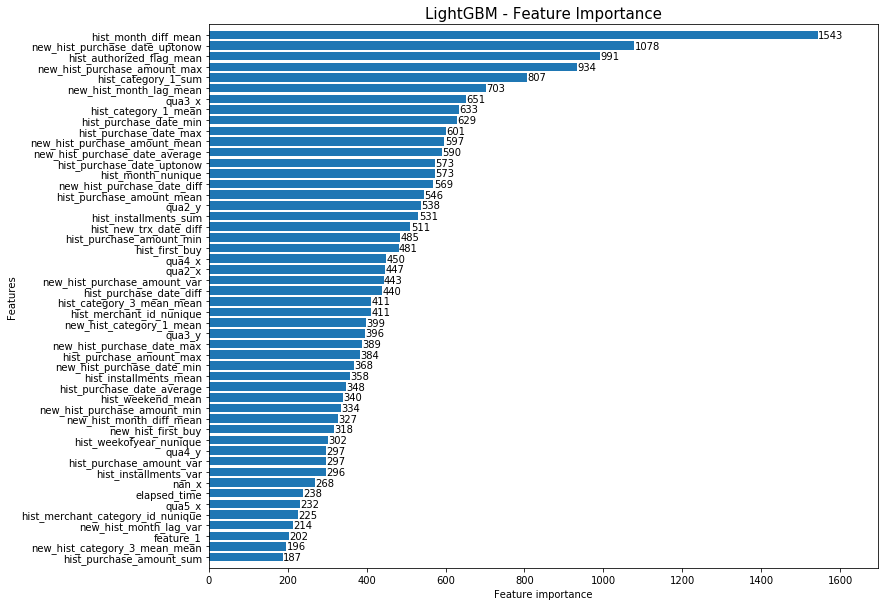

In [23]:
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### With Mean Feature_Importance

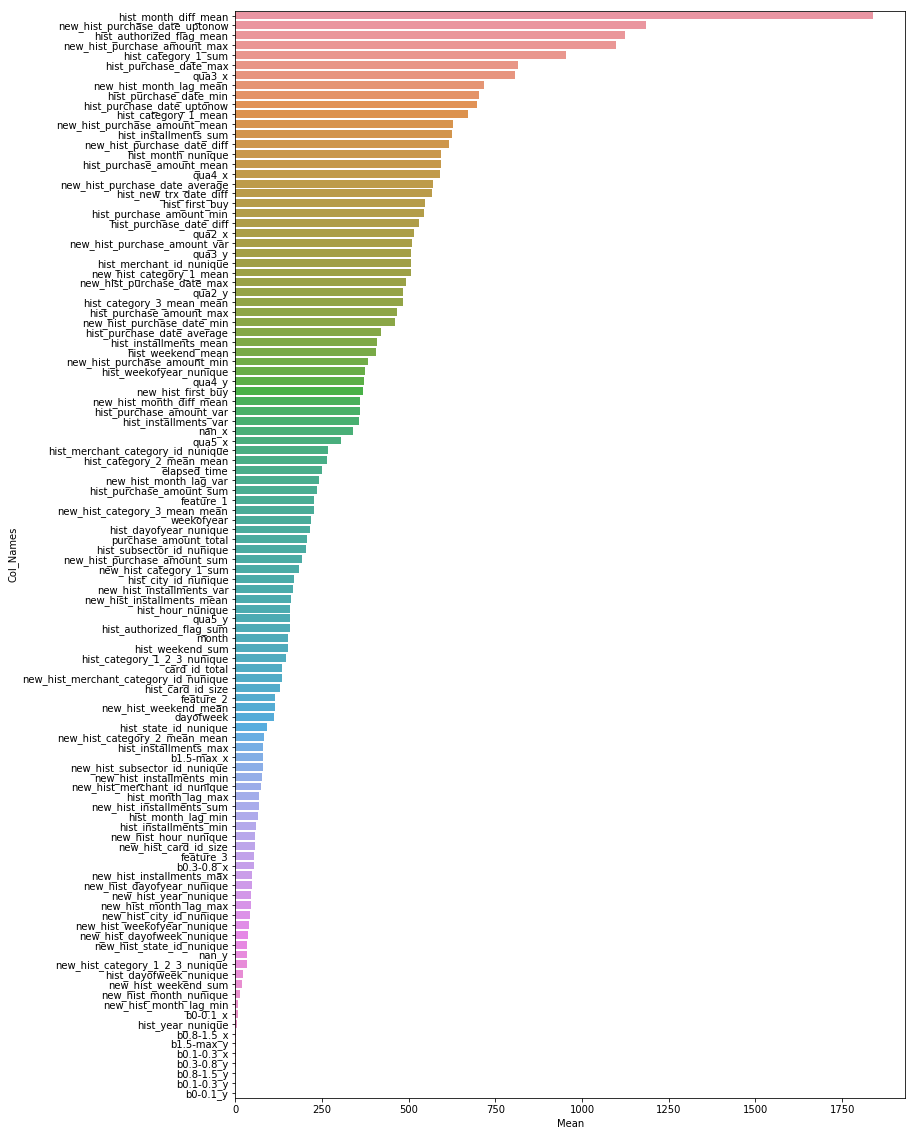

In [24]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,20))
sns.barplot(x="Mean", y="Col_Names", data = feature_imp, orient='h',ax=ax)
plt.show()